Idea is to plot I, Q, U, V as a function of hour angle to verify that they are continuous in the altaz-frame.

In [1]:
import six

In [2]:
import numpy as np
from astropy import units #import Quantity
from astropy import constants as const
from astropy.time import Time
from astropy.coordinates import Angle, SkyCoord, EarthLocation, AltAz
import pyuvsim
from pyuvsim import spherical_coordinates_basis_transformation as scbt
from pyuvsim import utils
import matplotlib.pyplot as plt
from matplotlib import rc
from IPython.display import clear_output
rc('text', usetex=True)
rc('font', family='serif')
rc('font',size=16)

In [3]:
def progress_bar(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1
        
    block = int(round(bar_length * progress))
    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [4]:
# Define the reference time and location
array_location = EarthLocation(lat='-30d43m17.5s', lon='21d25m41.9s', height=1073.)
time0 = Time('2018-03-01 18:00:00', scale='utc', location=array_location)

In [102]:
# Define the times
ha_off = 1/6.
dha = 0.1
dec_offset = Angle(0*units.degree)
time_offsets = np.arange(-ha_off,ha_off+dha,dha)
zero_indx = np.argmin(np.abs(time_offsets))
time_offsets[zero_indx] = 0.
times = time0 + time_offsets*units.hr
hr = (times.jd-time0.jd)*24.
ntimes = len(times)
#
zenith = SkyCoord(alt = 90.*units.deg, az = 0*units.deg, frame='altaz', obstime=time0, location=array_location)
zenith_icrs = zenith.transform_to('icrs')

In [103]:
src_astropy = SkyCoord(ra=zenith_icrs.ra,dec=zenith_icrs.dec+dec_offset, obstime=times, location=array_location)
src_astropy_altaz = src_astropy.transform_to('altaz')

In [133]:
src_astropy.hour_angle

AttributeError: 'SkyCoord' object has no attribute 'hour_angle'

In [132]:
np.isclose(src_astropy_altaz.alt.rad[zero_indx], np.pi / 2)

True

In [104]:
# Define the sources
freq = (150e6 * units.Hz)
stokes_radec = [1, -0.2, 0.3, 0.1]
###
decoff = 0.0*units.arcmin #-0.17*units.arcsec#0.0*units.arcmin
raoff = 0.0*units.arcsec
###
source = pyuvsim.SkyModel('icrs_zen', zenith_icrs.ra+raoff, zenith_icrs.dec+decoff, freq, stokes_radec)
#alt,az = source.alt_az_calc(time0,telescope_location=array_location)
#alt = alt*units.radian
#az = az*units.radian
#print('RA',source.ra.hour)
#print('Dec',source.dec.deg)
#print((90.*units.degree-alt.to(units.degree)).to(units.arcsec),az.to(units.degree))
#print(source.pos_lmn(time0,array_location))
coherency_radec = utils.stokes_to_coherency(stokes_radec)
print(coherency_radec)

[[0.4 +0.j   0.15-0.05j]
 [0.15+0.05j 0.6 +0.j  ]]


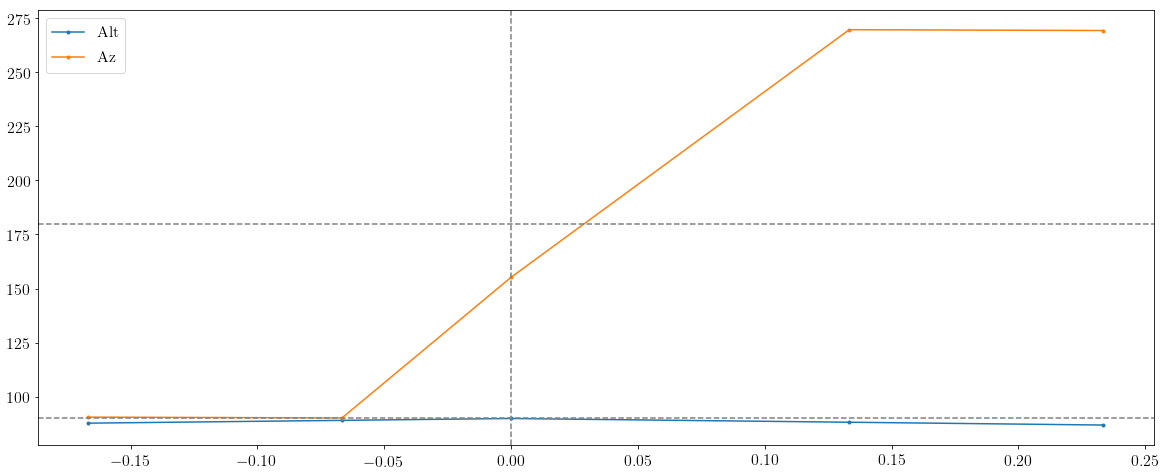

In [105]:
# The az that is coming out just doesn't make any sense at all
plt.figure(figsize=(20,8))
rc('font',size=16)
plt.plot(hr,src_astropy.altaz.alt.deg,'.-',label='Alt')
plt.plot(hr,src_astropy.altaz.az.deg,'.-',label='Az')
plt.axvline(0,color='gray',linestyle='--')
plt.axhline(180,color='gray',linestyle='--')
plt.axhline(90,color='gray',linestyle='--')
plt.legend()
plt.show()

In [106]:
# Save the time dependence of everything
ths = np.zeros([ntimes,3])
phs = np.zeros([ntimes,3])
bhs = np.zeros([ntimes,3])
ahs = np.zeros([ntimes,3])
R_matrices = np.zeros([ntimes,3,3])
betas = np.zeros(ntimes)
alphas = np.zeros(ntimes)
alts = np.zeros(ntimes)
azs = np.zeros(ntimes)
stokes_local = {'I':np.zeros(ntimes),'Q':np.zeros(ntimes),'U':np.zeros(ntimes),'V':np.zeros(ntimes)}
coherency_local = {'XX':np.zeros(ntimes,dtype='complex128'),
                   'XY':np.zeros(ntimes,dtype='complex128'),
                   'YX':np.zeros(ntimes,dtype='complex128'),
                   'YY':np.zeros(ntimes,dtype='complex128')}
coherency_matrix_local = np.zeros([2,2,ntimes],dtype='complex128')
cosXs = np.zeros(ntimes)
sinXs = np.zeros(ntimes)
# Check beta and alpha
# Problem seems to be sandwiched between _calc_basis_rotation_matrix which looks fine, 
# and spherical_basis_transformation_components, which is verkakte
for ti,time in enumerate(times):
    progress_bar(ti/float(times.size))
    source.update_positions(time,telescope_location=array_location)
    alt,az = source.alt_az #source.alt_az_calc(time,telescope_location=array_location)
    alts[ti] = alt
    azs[ti] = az
    basis_rot_matrix = source._calc_rotation_matrix(array_location)
    R_matrices[ti,:,:] = basis_rot_matrix.squeeze()
    vector_rotation = source._calc_coherency_rotation(array_location) #, th, ph, bh, ah, beta, alpha 
    #ths[ti,:] = th
    #phs[ti,:] = ph
    #bhs[ti,:] = bh
    #ahs[ti,:] = ah
    #betas[ti] = beta
    #alphas[ti] = alpha
    cosXs[ti] = vector_rotation[0,0]
    sinXs[ti] = vector_rotation[0,1]
    # This will be replaced with Source.coherency_calc(time, telescope_location)
    coherency_tmp = source.coherency_calc(array_location).squeeze() #np.einsum('ab,bc,cd->ad', vector_rotation.T, coherency_radec, vector_rotation)
    coherency_matrix_local[:,:,ti] = coherency_tmp
    coherency_local['XX'][ti] = coherency_tmp[0,0]
    coherency_local['XY'][ti] = coherency_tmp[0,1]
    coherency_local['YX'][ti] = coherency_tmp[1,0]
    coherency_local['YY'][ti] = coherency_tmp[1,1]    
    stokes_tmp = utils.coherency_to_stokes(coherency_tmp)
    stokes_local['I'][ti] = stokes_tmp[0]
    stokes_local['Q'][ti] = stokes_tmp[1]
    stokes_local['U'][ti] = stokes_tmp[2]
    stokes_local['V'][ti] = stokes_tmp[3]

Progress: [################----] 80.0%


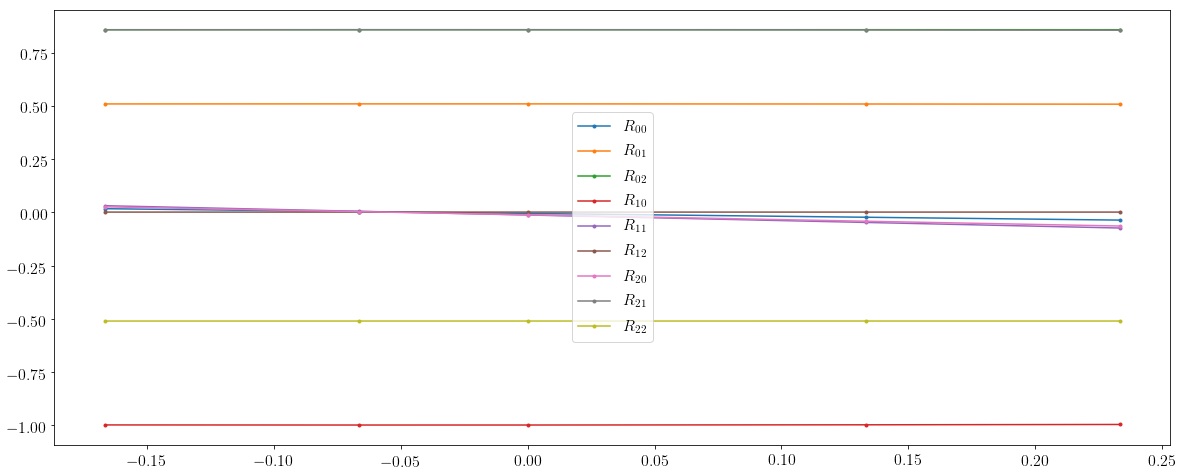

In [107]:
plt.figure(figsize=(20,8))
for i in np.arange(3):
    for j in np.arange(3):
        plt.plot(hr,R_matrices[:,i,j],'.-',label='$R_{'+str(i)+str(j)+'}$')
plt.legend()
plt.show()        

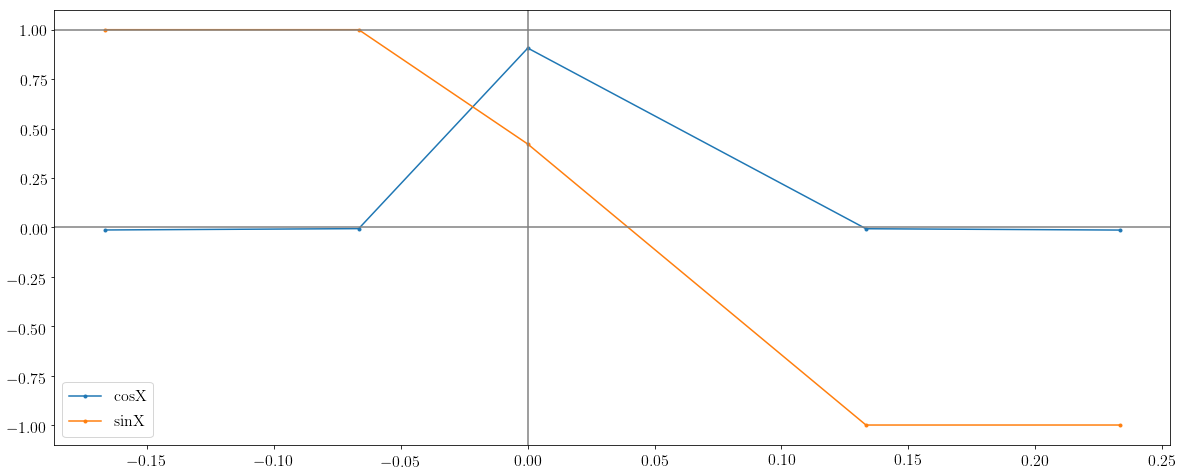

In [108]:
plt.figure(figsize=(20,8))
plt.plot(hr,cosXs,'.-',label='cosX')
#plt.plot(hr,np.abs(sinXs),'.-',label='abs(sinX)')
plt.plot(hr,sinXs,'.-',label='sinX')
plt.axhline(1,color='gray')
plt.axhline(0,color='gray')
plt.axvline(0,color='gray')
plt.legend()
#plt.xlim([-0.25,-0.25])
plt.show()

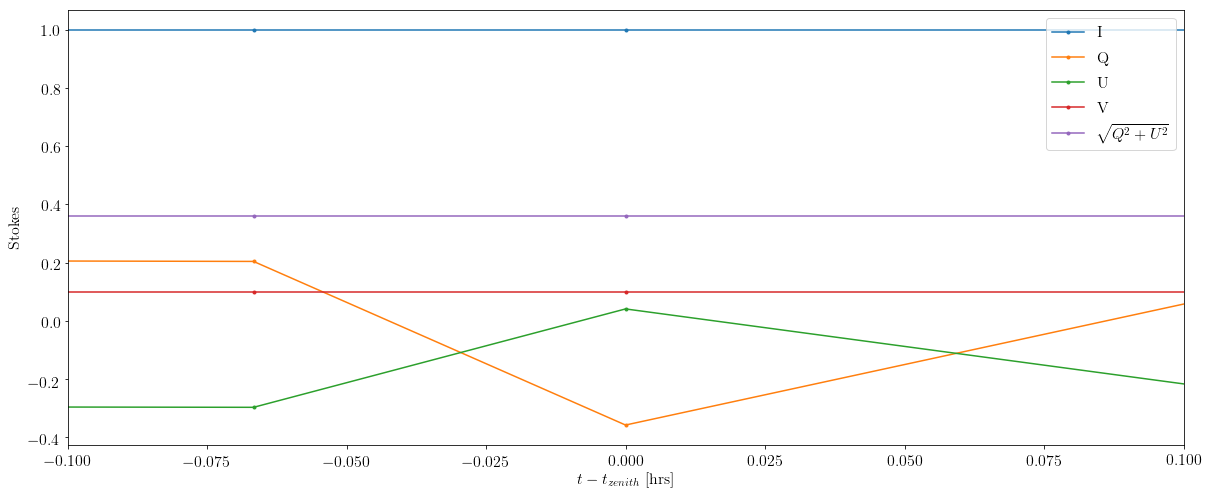

In [109]:
plt.figure(figsize=(20,8))
for sp in stokes_local.keys():
    plt.plot(hr,stokes_local[sp],'.-',label=sp)
plt.plot(hr,np.sqrt(stokes_local['Q']**2 + stokes_local['U']**2),'.-',label=r'$\sqrt{Q^2 + U^2}$')
plt.xlabel(r'$t - t_{zenith}$ [hrs]')
plt.ylabel('Stokes ')
plt.legend()
plt.xlim([-0.1,0.1])
plt.show()

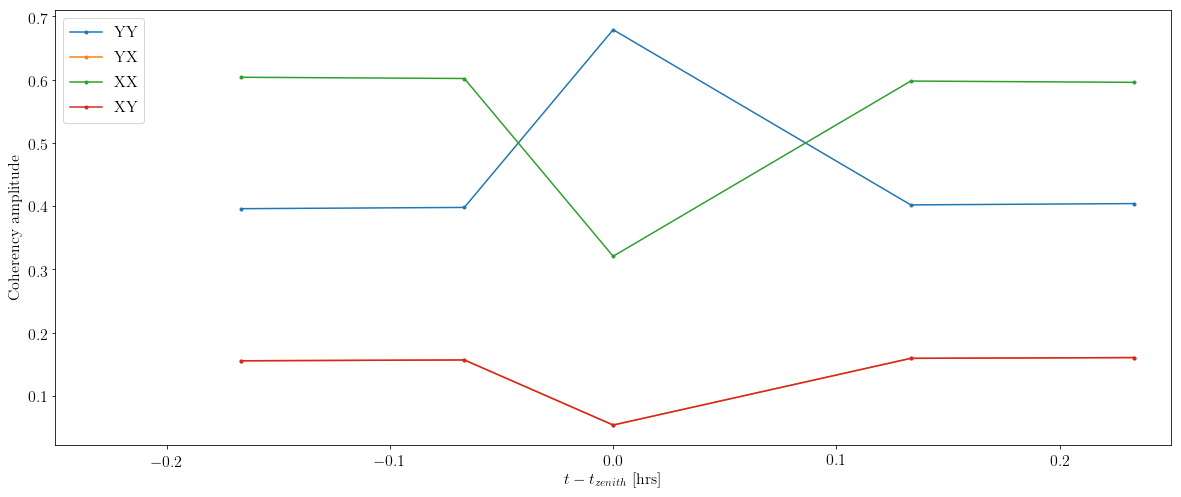

In [110]:
plt.figure(figsize=(20,8))
for sp in coherency_local.keys():
    plt.plot(hr,np.abs(coherency_local[sp]),'.-',label=sp)
#plt.plot(hr,np.sqrt(stokes_local['Q']**2 + stokes_local['U']**2),'.-',label=r'$\sqrt{Q^2 + U^2}$')
plt.xlabel(r'$t - t_{zenith}$ [hrs]')
plt.ylabel('Coherency amplitude')
plt.legend()
plt.xlim([-0.25,0.25])
plt.show()

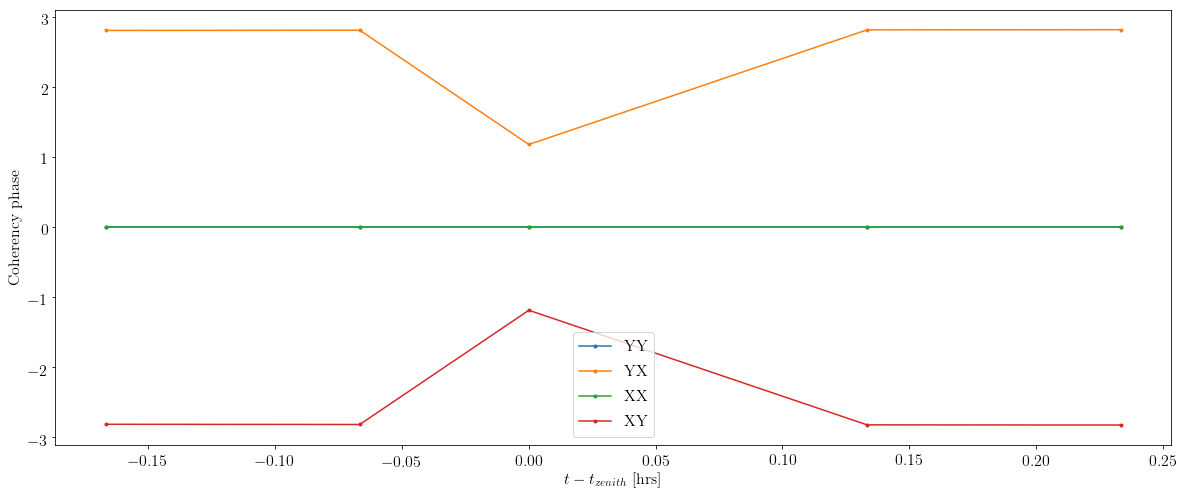

In [111]:
plt.figure(figsize=(20,8))
for sp in coherency_local.keys():
    plt.plot(hr,np.angle(coherency_local[sp]),'.-',label=sp)
#plt.plot(hr,np.sqrt(stokes_local['Q']**2 + stokes_local['U']**2),'.-',label=r'$\sqrt{Q^2 + U^2}$')
plt.xlabel(r'$t - t_{zenith}$ [hrs]')
plt.ylabel('Coherency phase')
plt.legend()
plt.show()

In [112]:
# This is for az increasing North through East
# and actual ZA
def analytic_beam_jones(za, az, sigma=0.3):
    #B = np.exp(-np.tan(za/2.)**2. / 2. / sigma**2.)
    B = 1
    J = np.array([[np.cos(za)*np.sin(az), np.cos(az)],
                 [np.cos(az)*np.cos(za), -np.sin(az)]])
    return B * J

In [113]:
zas = np.pi/2.-alts
Jbeam = analytic_beam_jones(zas,azs)

In [114]:
Jbeam.shape

(2, 2, 5)

In [115]:
Jbeam[:,:,Jbeam.shape[2]/2]

array([[ 0.41953074, -0.90774113],
       [-0.90774113, -0.41953074]])

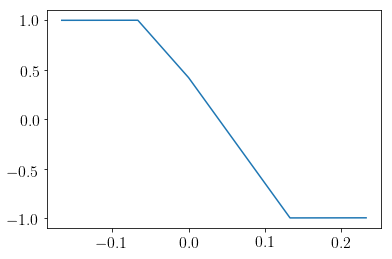

In [116]:
plt.plot(hr,Jbeam[0,0,:])

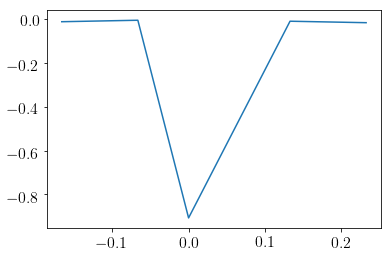

In [117]:
plt.plot(hr,Jbeam[0,1,:])

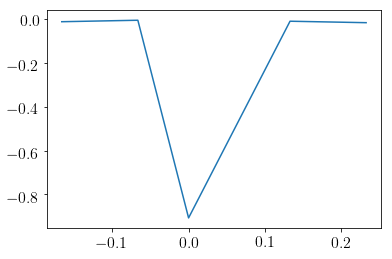

In [118]:
plt.plot(hr,Jbeam[1,0,:])

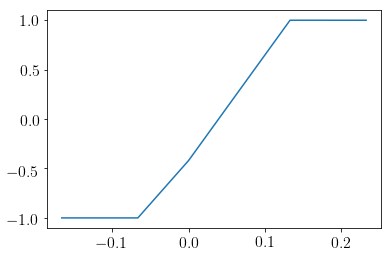

In [119]:
plt.plot(hr,Jbeam[1,1,:])

In [120]:
# Take the Jones beam times the coherency in the local basic and see how the bits come out
coherency_instr_local = np.einsum('ab...,bc...,dc...->ad...', Jbeam, coherency_matrix_local, np.conj(Jbeam))
# Brute force
coherency_instr_local2 = np.zeros([2,2,ntimes],dtype='complex128')
for ti in np.arange(ntimes):
    J = Jbeam[:,:,ti]
    C = coherency_matrix_local[:,:,ti]
    coherency_instr_local2[:,:,ti] = np.matmul(np.matmul(J,C),np.conj(J.T))

In [121]:
coherency_instr_local.shape

(2, 2, 5)

In [122]:
coherency_instr_local

array([[[0.60632557+0.00000000e+00j, 0.6031185 -2.71050543e-20j,
         0.60059597+0.00000000e+00j, 0.59464231+5.42101086e-20j,
         0.58939657+0.00000000e+00j],
        [0.14486082+4.99646382e-02j, 0.14776209+4.99943414e-02j,
         0.14960097+5.00000000e-02j, 0.15302905+4.99773672e-02j,
         0.15536376+4.99307015e-02j]],

       [[0.14486082-4.99646382e-02j, 0.14776209-4.99943414e-02j,
         0.14960097-5.00000000e-02j, 0.15302905-4.99773672e-02j,
         0.15536376-4.99307015e-02j],
        [0.39282051+0.00000000e+00j, 0.39674527+0.00000000e+00j,
         0.39940403+0.00000000e+00j, 0.40481652+5.42101086e-20j,
         0.40895287+0.00000000e+00j]]])

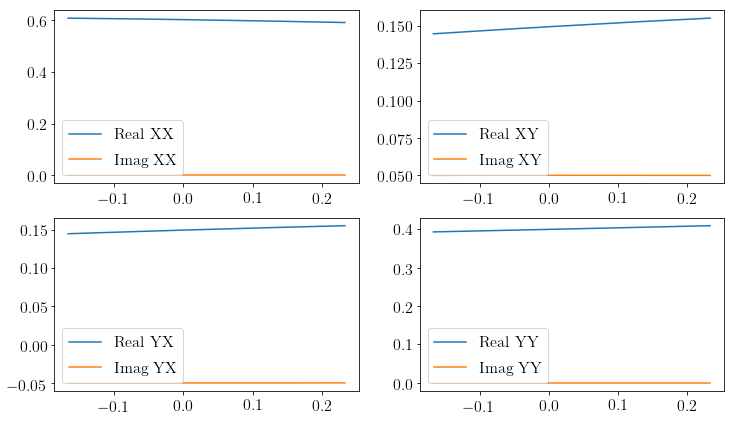

In [123]:
cohlab = ['XX','XY','YX','YY']
plt.figure(figsize=(12,7))
for i in [0,1]:
    for j in [0,1]:
        sp = 2*i+j
        plt.subplot(2,2,sp+1)
        plt.plot(hr,coherency_instr_local[i,j,:].real,label='Real '+cohlab[sp])
        plt.plot(hr,coherency_instr_local[i,j,:].imag,label='Imag '+cohlab[sp])
        #plt.plot(hr,np.abs(coherency_instr_local2[i,j,:]),label='Matmul '+cohlab[sp])
        plt.legend()
plt.show()

In [124]:
stokes_instr_local = utils.coherency_to_stokes(coherency_instr_local)

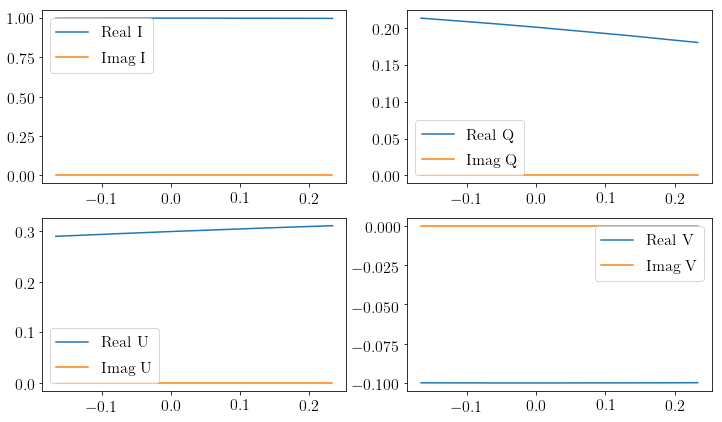

In [125]:
stoklab = ['I','Q','U','V']
plt.figure(figsize=(12,7))
for i in [0,1]:
    for j in [0,1]:
        sp = 2*i+j
        plt.subplot(2,2,sp+1)
        plt.plot(hr,stokes_instr_local[sp,:].real,label='Real '+stoklab[sp])
        plt.plot(hr,stokes_instr_local[sp,:].imag,label='Imag '+stoklab[sp])
        plt.legend()
plt.show()